<a href="https://colab.research.google.com/github/Debottam/MachinLearningEx/blob/master/tripletVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random
from sklearn.utils import check_random_state

In [2]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [4]:
# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

In [5]:
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

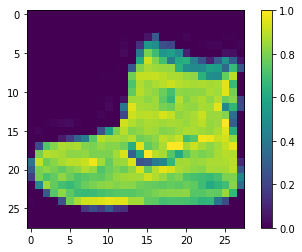

label:  9


In [6]:
show_image(train_images[0])
print("label: ",train_labels[0])

In [8]:
image_shoe_index = np.where(train_labels==9)
train_image_shoe = train_images[image_shoe_index]
print("shape before flattening: ",train_image_shoe.shape)
train_image_shoe_flatten = np.reshape(train_image_shoe, (6000, 784))
print("shape after flattening: ",train_image_shoe_flatten.shape)

shape before flattening:  (6000, 28, 28)
shape after flattening:  (6000, 784)


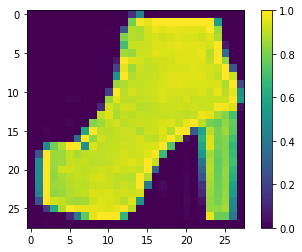

In [9]:
show_image(train_image_shoe[4])

In [10]:
image_tshirt_index = np.where(train_labels==0)
train_image_tshirt = train_images[image_tshirt_index]
print("shape before flattening: ",train_image_tshirt.shape)
train_image_tshirt_flatten = np.reshape(train_image_tshirt, (6000, 784))
print("shape after flattening: ",train_image_tshirt_flatten.shape)

shape before flattening:  (6000, 28, 28)
shape after flattening:  (6000, 784)


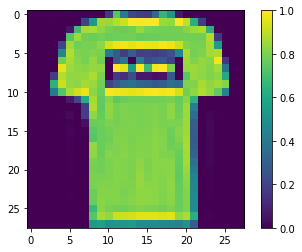

In [11]:
show_image(train_image_tshirt[0])

In [12]:
image_trouser_index = np.where(train_labels==1)
train_image_trouser = train_images[image_trouser_index]
print("shape before flattening: ",train_image_trouser.shape)
train_image_trouser_flatten = np.reshape(train_image_trouser, (6000, 784))
print("shape after flattening: ",train_image_trouser_flatten.shape)

shape before flattening:  (6000, 28, 28)
shape after flattening:  (6000, 784)


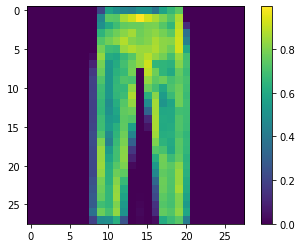

In [13]:
show_image(train_image_trouser[0])

In [14]:
def plot_triplet(triplet):
  plt.figure(figsize=(6,2))
  for i in range(0,3):
    plt.subplot(1,3,i+1)
    plt.imshow(np.reshape(triplet[i],(28,28)), cmap='binary')
    plt.xticks([])
    plt.yticks([])
  plt.show()

In [15]:
# concatenating tshirt and trouser
training_X = np.concatenate((train_image_tshirt_flatten, train_image_trouser_flatten), axis=0)

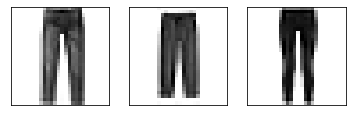

In [17]:
plot_triplet([training_X[6000],training_X[6001],training_X[6002]])

In [18]:
# generate labels tshirt = 0 and trouser = 1
train_y = np.concatenate((np.zeros(len(train_image_tshirt_flatten)), np.ones(len(train_image_trouser_flatten))), axis=0)

In [19]:
rng = check_random_state(1)
indices = rng.permutation(len(training_X))

In [20]:
# shuffled data and labels
training_X_shuffled = training_X[indices]
train_y_shuffled = train_y[indices]

0.0 0.0 1.0


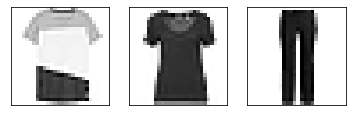

In [21]:
print(train_y_shuffled[6000],train_y_shuffled[6001],train_y_shuffled[6002])
plot_triplet([training_X_shuffled[6000],training_X_shuffled[6001],training_X_shuffled[6002]])

In [23]:
def create_batch (batch_size):
  anchors = np.zeros((batch_size, 784))
  positives = np.zeros((batch_size, 784))
  negatives = np.zeros((batch_size, 784))

  for i in range(0,batch_size):
    index = random.randint(0,12000-1)
    anc = training_X_shuffled[index]
    y = train_y_shuffled[index]

    indices_for_pos = np.squeeze(np.where(train_y_shuffled == y))
    indices_for_neg = np.squeeze(np.where(train_y_shuffled != y))

    pos = training_X_shuffled[indices_for_pos[random.randint(0,len(indices_for_pos)-1)]]
    neg = training_X_shuffled[indices_for_neg[random.randint(0,len(indices_for_neg)-1)]]

    anchors[i] = anc
    positives[i] = pos
    negatives[i] = neg

    return [anchors, positives, negatives] 

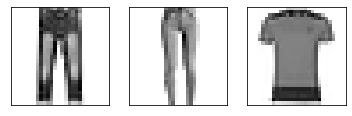

In [25]:
triplet = create_batch (1)
plot_triplet(triplet)

In [29]:
# building embedding layer
emb_dim = 64
embedding_model = tf.keras.models.Sequential([
                                tf.keras.layers.Dense(64, activation = 'relu', input_shape=(784,)),
                                tf.keras.layers.Dense(emb_dim, activation='sigmoid'),
                              ])
embedding_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [30]:
# take an example and predict output
example = training_X_shuffled[0]
print ("shape of example: ", example.shape)

example_emb = embedding_model.predict(np.expand_dims(example, axis = 0))

print ("shape of example_emb: ", example_emb.shape)

shape of example:  (784,)
shape of example_emb:  (1, 64)


In [32]:
# Declaring inputs
in_anc = tf.keras.layers.Input(shape = (784,))
in_pos = tf.keras.layers.Input(shape = (784,))
in_neg = tf.keras.layers.Input(shape = (784,))

im_anc_emb = embedding_model(in_anc)
im_pos_emb = embedding_model(in_pos)
im_neg_emb = embedding_model(in_neg)

In [35]:
# Declaring outputs
out = tf.keras.layers.concatenate([im_anc_emb, im_pos_emb, im_neg_emb], axis = 1)

# the full model
net = tf.keras.Model(inputs = [in_anc, in_pos, in_neg], outputs = out)

net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 64)           54400       input_4[0][0]                    
                                                                 input_5[0][0]              

Triplet loss:
  dp : distance between anchor and positive example
  dn : distance between anchor and negative example
  The job of training would make sure dp < dn
  if decrease dn by a scale factor then condition on dp would be tighter
  dp < dn - e

  so the condition would be 

  dp-dn+e < = 0

  and loss would be

  Loss = max (dp-dn+e, 0) // whichever is max will be reduced during training

In [46]:
# Defining triplet loss
def triplet_loss(emb_dim, alpha):
  def loss (y_truth, y_pred):
    anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:3*emb_dim]
    dp = tf.reduce_mean(tf.square(anc - pos), axis = 1)
    dn = tf.reduce_mean(tf.square(anc - neg), axis = 1)
    return tf.maximum(dp-dn+alpha, 0.)
  return loss

In [42]:
def data_generator(batch_size, emb_dim):
  while True:
    x = create_batch (batch_size)
    y = np.zeros((batch_size, 3*emb_dim))
    yield x, y


In [50]:
batch_size = 60
epochs = 20
steps_per_epoch = int(len(training_X_shuffled)/batch_size)
net.compile(loss = triplet_loss(emb_dim, alpha = 0.2), optimizer = 'adam' )

In [51]:
net.fit(data_generator(batch_size, emb_dim), epochs=epochs, steps_per_epoch=steps_per_epoch)

Epoch 1/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1969
Epoch 2/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1968
Epoch 3/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1969
Epoch 4/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1970
Epoch 5/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1967
Epoch 6/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1969
Epoch 7/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1968
Epoch 8/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1969
Epoch 9/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1969
Epoch 10/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1968
Epoch 11/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1969
Epoch 12/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1967
Epoch 13/20
200/200 [====

In [16]:
def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)